# MC2_Analysis_Part2: Scaler and Model Tuning

#### Import libraries

In [1]:
#basics
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
import matplotlib.pyplot as plt

#split train test library
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

#scalling 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

#Encoder
from sklearn.preprocessing import OneHotEncoder

#4 must model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


#grid searching/cross validate
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import GridSearchCV

#result and scoring, the aftermath 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error

#others
import math
from sklearn.exceptions import ConvergenceWarning
import time


#### Import Datasets

In [2]:
dataset1 = pd.read_csv('MC2_Datasets\Dataset_1.csv')
dataset2 = pd.read_csv('MC2_Datasets\Dataset_2.csv')
dataset3 = pd.read_csv('MC2_Datasets\Dataset_3.csv')

### Before we moving on....we have to tune scalers

treats data transforms as another hyperparameter of the modeling pipeline to be searched and tuned.
https://machinelearningmastery.com/grid-search-data-preparation-techniques/

Our method:
1) KNN Scaler Tuning (YES)

2) LR Scaler Tuning (NO)

3) GNB Scaler Tuning (YES)

4) RF Scaler Tuning (NO)


## K-Nearest Neighbors

### Scaler Tuning

stnd: 0.98315072 (0.00049979)
mnmx: 0.98190929 (0.00055799)
norm: 0.97685000 (0.00051477)
qtle: 0.98148288 (0.00043403)
rbst: 0.98248322 (0.00050436)


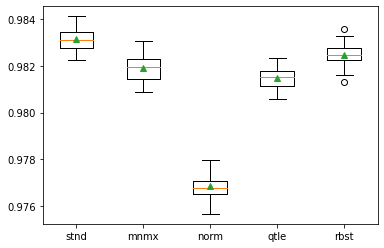

Process Duration: 3.0697 mins


In [3]:
#inputs
#-------------------------------------------------------------------------------------------------------#
#REMEMBER NEED TO CHANGE AH!
#which dataset(1,2,3,4)
###################################
datasetNo = 1 ########################
###################################

#n-neighbours
n = 11

#-------------------------------------------------------------------------------------------------------#
#start time
start = time.time()

def load_dataset(setNo):
    no = str(setNo)
    url = 'MC2_Datasets\Dataset_' + no + '.csv'
    dataset = pd.read_csv(url)
    X = dataset.iloc[:,1:-1]
    y = dataset.iloc[:,-1]
    return X,y

def evaluate_model(X,y,model):
    #define the cross-validation procedure
    cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=42)
    #evaluate model
    scores = cross_val_score(model,X,y,scoring='accuracy',cv=cv,n_jobs=1)
    return scores

def get_pipelines(model):
    pipelines = list()
    #standardize
    p = Pipeline([('s',StandardScaler()),('m',model)])
    pipelines.append(('stnd', p))
    #minmax
    p = Pipeline([('s',MinMaxScaler()),('m',model)])
    pipelines.append(('mnmx', p))
    #normalizer
    p = Pipeline([('s',Normalizer(norm='l2')),('m',model)])
    pipelines.append(('norm', p))
    #quantile
    p = Pipeline([('s',QuantileTransformer(n_quantiles=1000,output_distribution='normal')),('m',model)])
    pipelines.append(('qtle', p))
    #quantile
    p = Pipeline([('s',RobustScaler(quantile_range=(25.0,75.0))),('m',model)])
    pipelines.append(('rbst', p))
    return pipelines
 
    
X,y = load_dataset(datasetNo)
#define model
model = KNeighborsClassifier(n_neighbors=n)
# get the modeling pipelines
pipelines = get_pipelines(model)
#evaluate the each pipeline
results, model_names = list(),list()
scTune_result = []
for name,pipeline in pipelines:
    #evaluate
    scores = evaluate_model(X,y,pipeline)
    # summarize
    print('%s: %.8f (%.8f)' % (name,mean(scores),std(scores)))
    # store and plot
    results.append(scores)
    model_names.append(name)
# plot the result
plt.boxplot(results,labels=model_names,showmeans=True)
plt.show()

#end time
end = time.time()

#duration in minutes
duration = round(((end - start)/60),4)
duration = str(duration) + ' mins'
print("Process Duration:",duration)

scTune_history = {
    'TYPE' : 'SCTUNE',
    'DATETIME' : time.ctime(start), 
    'process_duration' : duration,
    'dataset' : datasetNo, 
    'model' : model
    }

try:
    f = open('MC2_Tune_Result.txt','a')
    f.write(str(scTune_history) + '\n')
    f.close()
except:
    print('File unable to append..')


### Model Tuning

In [4]:
#inputs
#-------------------------------------------------------------------------------------------------------#
#REMEMBER NEED TO CHANGE AH!
#which dataset(1,2,3)
###################################
datasetNo = 1 ########################
###################################

#set the train and test ratio
trainSize = 0.8
testSize = 0.2

#set the type of scaler(choose from the best)
scaler = StandardScaler()

#-------------------------------------------------------------------------------------------------------#
#start of thr process
start = time.time()

def load_and_split_dataset(setNo,train_size,test_size,random_state):
    no = str(setNo)
    url = 'MC2_Datasets\Dataset_' + no + '.csv'
    dataset = pd.read_csv(url)
    X = dataset.iloc[:,1:-1]
    y = dataset.iloc[:,-1]
    X_train,X_test,y_train,y_test = train_test_split(X, y, train_size=train_size, test_size=test_size,
                                                     random_state=random_state)
    
    return X_train,X_test,y_train,y_test

#load and split dataset
#don't change the random state
X_train,X_test,y_train,y_test = load_and_split_dataset(datasetNo,trainSize,testSize,42)


#SCALE DATA 
#--------------------------------------------------------------------------------------------------------#
#can try using different scaling methods
sc = scaler

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

#MODEL TUNING
#----------------------------------------------------------------------------------------------------------#
#model: KNN
model = KNeighborsClassifier()

#grid parameters
#WARNING: DO NOT PUT TOO MUCH HYPERPARAMETER OR ELSE YOUR DEVICE WILL SUFFER!
#Do not use brute algorithm!!
grid_params = [{
    'n_neighbors' : [7,9,11,13,15,17],
    'weights' : ['uniform','distance'],
    'algorithm' : ['ball_tree','kd_tree'],
    'metric' : ['euclidean','manhattan']
}]

#Full params list
#'n_neibors' : [any number],
#'weights' : ['uniform','distance'],
#'algorithm' : ['ball_tree','kd_tree','brute']
#'metric' : ['euclidean','manhattan','minkowski']

#start grid searching....might take some time...
#n_jobs = -1 -> use all cores, use up 100% of CPU
clf = GridSearchCV(model,grid_params,verbose=1,cv=3,n_jobs=1)

#fit data into the search
result = clf.fit(X_train,y_train)

#end process time
end = time.time()

#duration in minutes
duration = round(((end - start)/60),4)
duration = str(duration) + ' mins'
print("Process Duration:",duration)

#save test result into dictionary
params_history = {
    'TYPE' : 'PARAMS',
    'DATETIME' : time.ctime(start), 
    'dataset' : datasetNo, 
    'model' : model, 
    'scaler' : sc, 
    'grid_parameters' : grid_params 
    }

grid_result = { 
    'TYPE' : 'GRID',
    'DATETIME' : time.ctime(start), 
    'process_duration' : duration, 
    'dataset' : datasetNo, 
    'model' : model, 
    'scaler' : sc, 
    'best_parameters' : result.best_params_, 
    'best_score' : result.best_score_
    }

#write to file
try:
    f = open('MC2_Tune_Result.txt','a')
    f.write(str(params_history) + '\n')
    f.write(str(grid_result) + '\n')
    f.close()
except:
    print('File unable to append..')
     
print(result.best_estimator_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Process Duration: 29.0246 mins
KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_neighbors=11,
                     weights='distance')


### Prediction result

In [27]:
#AFTER FINISH MODEL TUNING
#start of thr process
start = time.time()

#fill in the best parameters you get from previous result
model = KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_neighbors=11,
                     weights='distance')

model.fit(X_train,y_train)
model.score(X_test,y_test)
y_pred = model.predict(X_test)

acs = accuracy_score(y_pred,y_test)
ps = precision_score(y_pred,y_test)
rs = recall_score(y_pred,y_test)
mse = mean_squared_error(y_test,y_pred)

#end time
end = time.time()

#duration in minutes
duration = round(((end - start)/60),4)
duration = str(duration) + ' mins'
print("Process Duration:",duration)

prediction_result = {
    'TYPE' : 'PRED',
    'DATETIME' : time.ctime(start), 
    'process_duration' : duration, 
    'dataset' : datasetNo, 
    'model' : model,
    'accuracy_score' : acs, 
    'precision_score' : ps,
    'recall_score' : rs,
    'mean_squared_error' : mse
    }

#write to file
try:
    f = open('MC2_Tune_Result.txt','a')
    f.write(str(prediction_result) + '\n')
    f.close()
except:
    print('File unable to append..')


Process Duration: 0.5529 mins


## Logistic Regression

### Scaler Tuning

stnd: 0.97757147 (0.00031185)
mnmx: 0.97557259 (0.00018525)
norm: 0.97495007 (0.00001619)
qtle: 0.97503823 (0.00006789)
rbst: 0.97757327 (0.00031279)


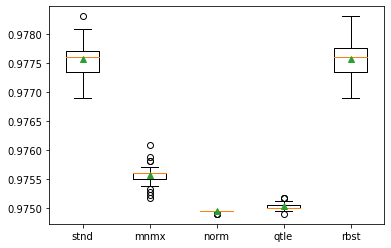

Process Duration: 2.5959 mins


In [28]:
#inputs
#-------------------------------------------------------------------------------------------------------#
#REMEMBER NEED TO CHANGE AH!
#which dataset(1,2,3,4)
###################################
datasetNo = 1 ########################
###################################

#penalty
p = 'l2'
#C
c = 1.0
#fit_intercept
ft = True
#tolerence, acceptable error range
t = 1e-4
#solver
s = 'sag'

#-------------------------------------------------------------------------------------------------------#
#start time
start = time.time()

def load_dataset(setNo):
    no = str(setNo)
    url = 'MC2_Datasets\Dataset_' + no + '.csv'
    dataset = pd.read_csv(url)
    X = dataset.iloc[:,1:-1]
    y = dataset.iloc[:,-1]
    return X,y

def evaluate_model(X,y,model):
    #define the cross-validation procedure
    cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=42)
    #evaluate model
    scores = cross_val_score(model,X,y,scoring='accuracy',cv=cv,n_jobs=1)
    return scores

def get_pipelines(model):
    pipelines = list()
    #standardize
    p = Pipeline([('s',StandardScaler()),('m',model)])
    pipelines.append(('stnd', p))
    #minmax
    p = Pipeline([('s',MinMaxScaler()),('m',model)])
    pipelines.append(('mnmx', p))
    #normalizer
    p = Pipeline([('s',Normalizer(norm='l2')),('m',model)])
    pipelines.append(('norm', p))
    #quantile
    p = Pipeline([('s',QuantileTransformer(n_quantiles=10000,output_distribution='normal')),('m',model)])
    pipelines.append(('qtle', p))
    #quantile
    p = Pipeline([('s',RobustScaler(quantile_range=(25.0,75.0))),('m',model)])
    pipelines.append(('rbst', p))
    return pipelines
 

X,y = load_dataset(datasetNo)
#define model
model = LogisticRegression(penalty=p, C=c, fit_intercept=ft, tol=t, solver=s)
# get the modeling pipelines
pipelines = get_pipelines(model)
#evaluate the each pipeline
results, model_names = list(),list()
scTune_result = []
for name,pipeline in pipelines:
    #evaluate
    scores = evaluate_model(X,y,pipeline)
    # summarize
    print('%s: %.8f (%.8f)' % (name,mean(scores),std(scores)))
    # store and plot
    results.append(scores)
    model_names.append(name)
# plot the result
plt.boxplot(results,labels=model_names,showmeans=True)
plt.show()

#end time
end = time.time()

#duration in minutes
duration = round(((end - start)/60),4)
duration = str(duration) + ' mins'
print("Process Duration:",duration)

scTune_history = {
    'TYPE' : 'SCTUNE',
    'DATETIME' : time.ctime(start), 
    'process_duration' : duration,
    'dataset' : datasetNo, 
    'model' : model
    }

try:
    f = open('MC2_Tune_Result.txt','a')
    f.write(str(scTune_history) + '\n')
    f.close()
except:
    print('File unable to append..')


### Model Tuning

In [29]:
#inputs
#-------------------------------------------------------------------------------------------------------#
#REMEMBER NEED TO CHANGE AH!
#which dataset(1,2,3,4)
###################################
datasetNo = 1 ########################
###################################

#set the train and test ratio
trainSize = 0.8
testSize = 0.2

#the data for this model does not require scalling
#scaler = None

#-------------------------------------------------------------------------------------------------------#
#start of thr process
start = time.time()

def load_and_split_dataset(setNo,train_size,test_size,random_state):
    no = str(setNo)
    url = 'MC2_Datasets\Dataset_' + no + '.csv'
    dataset = pd.read_csv(url)
    X = dataset.iloc[:,1:-1]
    y = dataset.iloc[:,-1]
    X_train,X_test,y_train,y_test = train_test_split(X, y, train_size=train_size, test_size=test_size,
                                                     random_state=random_state)
    
    return X_train,X_test,y_train,y_test

#load and split dataset
#don't change the random state
X_train,X_test,y_train,y_test = load_and_split_dataset(datasetNo,trainSize,testSize,42)


#MODEL TUNING
#----------------------------------------------------------------------------------------------------------#
#model
model = LogisticRegression()

#grid parameters
#WARNING: DO NOT PUT TOO MUCH HYPERPARAMETER OR ELSE YOUR DEVICE WILL SUFFER!
#for multiple parameter grids, can put multiple set of dict into list
grid_params = [{
    'C': list(np.arange(1000, 3000, 200)), #c = constant values in the array
    'fit_intercept': [True, False],
    'tol' : [1e-5,1e-4,1e-6], #acceptable error range
    'solver' : ['newton-cg','sag','saga','lbfgs']
    }]

#note:
#‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. 
#‘elasticnet’ is only supported by the ‘saga’ solver. 
#'none' (not supported by the liblinear solver)

#Full params list
#'penalty' : ['l1', 'l2', 'elasticnet', 'none']
#'C' : [any number],
#'fit_intercept' : [True, False],
#'tol' : [1e-5,1e-4] or any number(list)
#'solver' : ['newton-cg','lbfgs','liblinear', 'sag', 'saga']

#start grid searching....might take some time...
#n_jobs = -1 -> use all cores, use up 100% of CPU
clf = GridSearchCV(model,grid_params,verbose=1,cv=3,n_jobs=1)

#fit data into the search
result = clf.fit(X_train,y_train)

#end process time
end = time.time()

#duration in minutes
duration = round(((end - start)/60),4)
duration = str(duration) + ' mins'
print("Process Duration:",duration)

#save test result into dictionary
params_history = {
    'TYPE' : 'PARAMS',
    'DATETIME' : time.ctime(start), 
    'dataset' : datasetNo, 
    'model' : model, 
    'scaler' : 'na', 
    'grid_parameters' : grid_params 
    }

grid_result = { 
    'TYPE' : 'GRID',
    'DATETIME' : time.ctime(start), 
    'process_duration' : duration, 
    'dataset' : datasetNo, 
    'model' : model, 
    'scaler' : 'na', 
    'best_parameters' : result.best_params_, 
    'best_score' : result.best_score_
    }
#write to file
try:
    f = open('MC2_Tune_Result.txt','a')
    f.write(str(params_history) + '\n')
    f.write(str(grid_result) + '\n')
    f.close()
except:
    print('File unable to append..')
     
print(result.best_estimator_)


Fitting 3 folds for each of 240 candidates, totalling 720 fits


c:\users\user\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge


c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdat

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdat

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdat

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdat

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdat

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdat

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\users\user\appdat

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The

Process Duration: 10.394 mins
LogisticRegression(C=1000, solver='newton-cg', tol=1e-05)


### Prediction Result

In [30]:
#AFTER FINISH MODEL TUNING
#start of thr process
start = time.time()

#fill in the best parameters you get from previous result
model = LogisticRegression(C=1000, solver='newton-cg', tol=1e-05)

model.fit(X_train,y_train)
model.score(X_test,y_test)
y_pred = model.predict(X_test)

acs = accuracy_score(y_pred,y_test)
ps = precision_score(y_pred,y_test)
rs = recall_score(y_pred,y_test)
mse = mean_squared_error(y_test,y_pred)

#end time
end = time.time()

#duration in minutes
duration = round(((end - start)/60),4)
duration = str(duration) + ' mins'
print("Process Duration:",duration)

prediction_result = {
    'TYPE' : 'PRED',
    'DATETIME' : time.ctime(start), 
    'process_duration' : duration, 
    'dataset' : datasetNo, 
    'model' : model,
    'accuracy_score' : acs, 
    'precision_score' : ps,
    'recall_score' : rs,
    'mean_squared_error' : mse
    }

#write to file
try:
    f = open('MC2_Tune_Result.txt','a')
    f.write(str(prediction_result) + '\n')
    f.close()
except:
    print('File unable to append..')


Process Duration: 0.0313 mins


## Naive Bayes (Gaussian)

### Scaler Tuning

stnd: 0.96694194 (0.00109227)
mnmx: 0.96694194 (0.00109227)
norm: 0.97198683 (0.00086473)
qtle: 0.97658193 (0.00039706)
rbst: 0.96694194 (0.00109227)
pwtf: 0.96373221 (0.00126905)


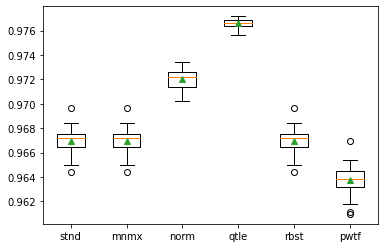

Process Duration: 0.9258 mins


In [4]:
#inputs
#-------------------------------------------------------------------------------------------------------#
#REMEMBER NEED TO CHANGE AH!
#which dataset(1,2,3,4)
###################################
datasetNo = 1 ########################
###################################

#prior
p = None
#fit prior
vs = 1e-9


#-------------------------------------------------------------------------------------------------------#
#start time
start = time.time()

def load_dataset(setNo):
    no = str(setNo)
    url = 'MC2_Datasets\Dataset_' + no + '.csv'
    dataset = pd.read_csv(url)
    X = dataset.iloc[:,1:-1]
    y = dataset.iloc[:,-1]
    return X,y

def evaluate_model(X,y,model):
    #define the cross-validation procedure
    cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=42)
    #evaluate model
    scores = cross_val_score(model,X,y,scoring='accuracy',cv=cv,n_jobs=1)
    return scores

def get_pipelines(model):
    pipelines = list()
    #standardize
    p = Pipeline([('s',StandardScaler()),('m',model)])
    pipelines.append(('stnd', p))
    #minmax
    p = Pipeline([('s',MinMaxScaler()),('m',model)])
    pipelines.append(('mnmx', p))
    #normalizer
    p = Pipeline([('s',Normalizer(norm='l1')),('m',model)])
    pipelines.append(('norm', p))
    #quantile
    p = Pipeline([('s',QuantileTransformer(n_quantiles=10000,output_distribution='normal')),('m',model)])
    pipelines.append(('qtle', p))
    #quantile
    p = Pipeline([('s',RobustScaler(quantile_range=(25.0,75.0))),('m',model)])
    pipelines.append(('rbst', p))
    #powertransformer
    p = Pipeline([('s',PowerTransformer(method='yeo-johnson')),('m',model)])
    pipelines.append(('pwtf', p))
    return pipelines

 

X,y = load_dataset(datasetNo)
#define model
model = GaussianNB(priors=p,var_smoothing=vs)
# get the modeling pipelines
pipelines = get_pipelines(model)
#evaluate the each pipeline
results, model_names = list(),list()
scTune_result = []
for name,pipeline in pipelines:
    #evaluate
    scores = evaluate_model(X,y,pipeline)
    # summarize
    print('%s: %.8f (%.8f)' % (name,mean(scores),std(scores)))
    # store and plot
    results.append(scores)
    model_names.append(name)
# plot the result
plt.boxplot(results,labels=model_names,showmeans=True)
plt.show()

#end time
end = time.time()

#duration in minutes
duration = round(((end - start)/60),4)
duration = str(duration) + ' mins'
print("Process Duration:",duration)

scTune_history = {
    'TYPE' : 'SCTUNE',
    'DATETIME' : time.ctime(start), 
    'process_duration' : duration,
    'dataset' : datasetNo, 
    'model' : model
    }

try:
    f = open('MC2_Tune_Result.txt','a')
    f.write(str(scTune_history) + '\n')
    f.close()
except:
    print('File unable to append..')


### Model Tuning

In [5]:
#inputs
#-------------------------------------------------------------------------------------------------------#
#REMEMBER NEED TO CHANGE AH!
#which dataset(1,2,3)
###################################
datasetNo = 1 ########################
###################################

#set the train and test ratio
trainSize = 0.8
testSize = 0.2

#set the scaler(use the best obtained from above)
scaler = QuantileTransformer(n_quantiles=10000,output_distribution='normal')

#-------------------------------------------------------------------------------------------------------#
#start of thr process
start = time.time()

def load_and_split_dataset(setNo,train_size,test_size,random_state):
    no = str(setNo)
    url = 'MC2_Datasets\Dataset_' + no + '.csv'
    dataset = pd.read_csv(url)
    X = dataset.iloc[:,1:-1]
    y = dataset.iloc[:,-1]
    X_train,X_test,y_train,y_test = train_test_split(X, y, train_size=train_size, test_size=test_size,
                                                     random_state=random_state)
    
    return X_train,X_test,y_train,y_test

#load and split dataset
#don't change the random state
X_train,X_test,y_train,y_test = load_and_split_dataset(datasetNo,trainSize,testSize,42)


#SCALE DATA 
#--------------------------------------------------------------------------------------------------------#
#can try using different scaling methods
sc = scaler

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

#MODEL TUNING
#----------------------------------------------------------------------------------------------------------#
#model
model = GaussianNB()

#grid parameters
#WARNING: DO NOT PUT TOO MUCH HYPERPARAMETER OR ELSE YOUR DEVICE WILL SUFFER!
#for multiple parameter grids, can put multiple set of dict into list
grid_params = [{
    'var_smoothing' : [1e-2,1e-5,1e-7,1e-9,1e-11,1e-13]
    }]

#Full params list
#'priors' : [array like of shape] -> no need to use
#'var_smoothing' : [any number,float],

#start grid searching....might take some time...
#n_jobs = -1 -> use all cores, use up 100% of CPU
clf = GridSearchCV(model,grid_params,verbose=1,cv=3,n_jobs=1)

#fit data into the search
result = clf.fit(X_train,y_train)

#end process time
end = time.time()

#duration in minutes
duration = round(((end - start)/60),4)
duration = str(duration) + ' mins'
print("Process Duration:",duration)

#save test result into dictionary
params_history = {
    'TYPE' : 'PARAMS',
    'DATETIME' : time.ctime(start), 
    'dataset' : datasetNo, 
    'model' : model, 
    'scaler' : sc, 
    'grid_parameters' : grid_params 
    }

grid_result = { 
    'TYPE' : 'GRID',
    'DATETIME' : time.ctime(start), 
    'process_duration' : duration, 
    'dataset' : datasetNo, 
    'model' : model, 
    'scaler' : sc, 
    'best_parameters' : result.best_params_, 
    'best_score' : result.best_score_
    }
#write to file
try:
    f = open('MC2_Tune_Result.txt','a')
    f.write(str(params_history) + '\n')
    f.write(str(grid_result) + '\n')
    f.close()
except:
    print('File unable to append..')
     
print(result.best_estimator_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Process Duration: 0.0956 mins
GaussianNB(var_smoothing=1e-05)


### Prediction Result

In [6]:
#AFTER FINISH MODEL TUNING
#start of thr process
start = time.time()

#fill in the best parameters you get from previous result
model = GaussianNB(var_smoothing=1e-05)

model.fit(X_train,y_train)
model.score(X_test,y_test)
y_pred = model.predict(X_test)

acs = accuracy_score(y_pred,y_test)
ps = precision_score(y_pred,y_test)
rs = recall_score(y_pred,y_test)
mse = mean_squared_error(y_test,y_pred)

#end time
end = time.time()

#duration in minutes
duration = round(((end - start)/60),4)
duration = str(duration) + ' mins'
print("Process Duration:",duration)

prediction_result = {
    'TYPE' : 'PRED',
    'DATETIME' : time.ctime(start), 
    'process_duration' : duration, 
    'dataset' : datasetNo, 
    'model' : model,
    'accuracy_score' : acs, 
    'precision_score' : ps,
    'recall_score' : rs,
    'mean_squared_error' : mse
    }

#write to file
try:
    f = open('MC2_Tune_Result.txt','a')
    f.write(str(prediction_result) + '\n')
    f.close()
except:
    print('File unable to append..')


Process Duration: 0.0013 mins


## Random Forest

### Scaler Tuning

stnd: 0.99527900 (0.00049284)
mnmx: 0.99533848 (0.00051166)
norm: 0.99134144 (0.00086624)
qtle: 0.99531299 (0.00045753)
rbst: 0.99534018 (0.00050432)


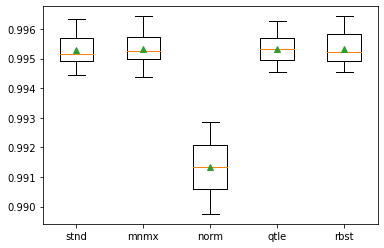

Process Duration: 111.5025 mins


In [47]:
#inputs
#-------------------------------------------------------------------------------------------------------#
#REMEMBER NEED TO CHANGE AH!
#which dataset(1,2,3,4)
###################################
datasetNo = 3 ########################
###################################

#n estimator(int)
ne = 100
#criterion{“gini”, “entropy”}, default=”gini”
c = 'gini'
#max_depth:int, default=None
md = None
#min_samples_split:int or float, default=2
mss = 2
#min_samples_leaf:int or float, default=1
msl = 1
#min_weight_fraction_leaf:float, default=0.0
mwfl = 0.0
#max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
mf = 'auto' 
#max_leaf_nodes:int, default=None
mln = None
#min_impurity_decrease:float, default=0.0
mid = 0.0
#bootstrap:bool, default=True
b = True
#oob_score:bool, default=False
oob = False
#n jobs:default = None
nj = None
#random_state:int, RandomState instance or None, default=None
rs = None
#verbose:int, default=0
v = 0
#warm_start:bool, default=False
ws = False
#class_weight{“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
cw = None
#ccp_alpha:non-negative float, default=0.0
ccp = 0.0
#max_samples:int or float, default=None
ms = None


#-------------------------------------------------------------------------------------------------------#
#start time
start = time.time()

def load_dataset(setNo):
    no = str(setNo)
    url = 'MC2_Datasets\Dataset_' + no + '.csv'
    dataset = pd.read_csv(url)
    X = dataset.iloc[:,1:-1]
    y = dataset.iloc[:,-1]
    return X,y

def evaluate_model(X,y,model):
    #define the cross-validation procedure
    cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=42)
    #evaluate model
    scores = cross_val_score(model,X,y,scoring='accuracy',cv=cv,n_jobs=1)
    return scores

def get_pipelines(model):
    pipelines = list()
    #standardize
    p = Pipeline([('s',StandardScaler()),('m',model)])
    pipelines.append(('stnd', p))
    #minmax
    p = Pipeline([('s',MinMaxScaler()),('m',model)])
    pipelines.append(('mnmx', p))
    #normalizer
    p = Pipeline([('s',Normalizer(norm='l2')),('m',model)])
    pipelines.append(('norm', p))
    #quantile
    p = Pipeline([('s',QuantileTransformer(n_quantiles=10000,output_distribution='normal')),('m',model)])
    pipelines.append(('qtle', p))
    #quantile
    p = Pipeline([('s',RobustScaler(quantile_range=(25.0,75.0))),('m',model)])
    pipelines.append(('rbst', p))
    return pipelines
 

X,y = load_dataset(datasetNo)
#define model
model = RandomForestClassifier(
    n_estimators=ne,criterion=c,max_depth=md,min_samples_split=mss,
    min_samples_leaf=msl,min_weight_fraction_leaf=mwfl,max_features=mf,
    max_leaf_nodes=mln,min_impurity_decrease=mid,bootstrap=b,oob_score=oob,
    n_jobs=nj,random_state=rs,verbose=v,warm_start=ws,class_weight=cw,
    ccp_alpha=ccp,max_samples=ms
)
# get the modeling pipelines
pipelines = get_pipelines(model)
#evaluate the each pipeline
results, model_names = list(),list()
scTune_result = []
for name,pipeline in pipelines:
    #evaluate
    scores = evaluate_model(X,y,pipeline)
    # summarize
    print('%s: %.8f (%.8f)' % (name,mean(scores),std(scores)))
    # store and plot
    results.append(scores)
    model_names.append(name)
# plot the result
plt.boxplot(results,labels=model_names,showmeans=True)
plt.show()

#end time
end = time.time()

#duration in minutes
duration = round(((end - start)/60),4)
duration = str(duration) + ' mins'
print("Process Duration:",duration)

scTune_history = {
    'TYPE' : 'SCTUNE',
    'DATETIME' : time.ctime(start), 
    'process_duration' : duration,
    'dataset' : datasetNo, 
    'model' : model
    }

try:
    f = open('MC2_Tune_Result.txt','a')
    f.write(str(scTune_history) + '\n')
    f.close()
except:
    print('File unable to append..')


### Model Tuning

In [7]:
#inputs
#-------------------------------------------------------------------------------------------------------#
#REMEMBER NEED TO CHANGE AH!
#which dataset(1,2,3)
###################################
datasetNo = 5 ########################
###################################

#set the train and test ratio
trainSize = 0.8
testSize = 0.2

#the data for this model does not require scaling
#scaler = None

#-------------------------------------------------------------------------------------------------------#
#start of thr process
start = time.time()

def load_and_split_dataset(setNo,train_size,test_size,random_state):
    no = str(setNo)
    url = 'MC2_Datasets\Dataset_' + no + '.csv'
    dataset = pd.read_csv(url)
    X = dataset.iloc[:,1:-1]
    y = dataset.iloc[:,-1]
    X_train,X_test,y_train,y_test = train_test_split(X, y, train_size=train_size, test_size=test_size,
                                                     random_state=random_state)
    
    return X_train,X_test,y_train,y_test

#load and split dataset
#don't change the random state
X_train,X_test,y_train,y_test = load_and_split_dataset(datasetNo,trainSize,testSize,42)


#MODEL TUNING
#----------------------------------------------------------------------------------------------------------#
#model
model = RandomForestClassifier()

#grid parameters
#WARNING: DO NOT PUT TOO MUCH HYPERPARAMETER OR ELSE YOUR DEVICE WILL SUFFER!
#for multiple parameter grids, can put multiple set of dict into list
grid_params = [{
    'n_estimators' : list(np.arange(100,600,100)),
    'criterion' : ['gini','entropy'],
    'max_depth' : [100,None],
    'max_features' : [2,'auto']
    }]

#Full params list
#'priors' : [array like of shape] -> no need to use
#'var_smoothing' : [any number,float],

#start grid searching....might take some time...
#n_jobs = -1 -> use all cores, use up 100% of CPU
clf = GridSearchCV(model,grid_params,verbose=1,cv=3,n_jobs=1)

#fit data into the search
result = clf.fit(X_train,y_train)

#end process time
end = time.time()

#duration in minutes
duration = round(((end - start)/60),4)
duration = str(duration) + ' mins'
print("Process Duration:",duration)

#save test result into dictionary
params_history = {
    'TYPE' : 'PARAMS',
    'DATETIME' : time.ctime(start), 
    'dataset' : datasetNo, 
    'model' : model, 
    'scaler' : 'na', 
    'grid_parameters' : grid_params 
    }

grid_result = { 
    'TYPE' : 'GRID',
    'DATETIME' : time.ctime(start), 
    'process_duration' : duration, 
    'dataset' : datasetNo, 
    'model' : model, 
    'scaler' : 'na', 
    'best_parameters' : result.best_params_, 
    'best_score' : result.best_score_
    }
#write to file
try:
    f = open('MC2_Tune_Result.txt','a')
    f.write(str(params_history) + '\n')
    f.write(str(grid_result) + '\n')
    f.close()
except:
    print('File unable to append..')
     
print(result.best_estimator_)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Process Duration: 161.4697 mins
RandomForestClassifier(max_depth=100, max_features=2)


### Prediction Result

In [8]:
#AFTER FINISH MODEL TUNING
#start of thr process
start = time.time()

#fill in the best parameters you get from previous result
model = RandomForestClassifier(max_depth=100, max_features=2)

model.fit(X_train,y_train)
model.score(X_test,y_test)
y_pred = model.predict(X_test)

acs = accuracy_score(y_pred,y_test)
ps = precision_score(y_pred,y_test)
rs = recall_score(y_pred,y_test)
mse = mean_squared_error(y_test,y_pred)

#end time
end = time.time()

#duration in minutes
duration = round(((end - start)/60),4)
duration = str(duration) + ' mins'
print("Process Duration:",duration)


prediction_result = {
    'TYPE' : 'PRED',
    'DATETIME' : time.ctime(start), 
    'process_duration' : duration, 
    'dataset' : datasetNo, 
    'model' : model,
    'accuracy_score' : acs, 
    'precision_score' : ps,
    'recall_score' : rs,
    'mean_squared_error' : mse
    }

#write to file
try:
    f = open('MC2_Tune_Result.txt','a')
    f.write(str(prediction_result) + '\n')
    f.close()
except:
    print('File unable to append..')



Process Duration: 0.7552 mins


## Final results (Evaluation)

In [1]:
def rounding(arr):
    for i in range(len(arr)):
        arr[i] = round(arr[i],5) * 100
    return arr

### The scores for each datasets in different models

In [3]:
#dataset1
accuracy = rounding([0.9832136881308361,0.9781130242349004,0.9771684568467642,0.9833486263291412])
precision = rounding([0.9991149218641958,0.9999723413082561,0.9991702392476836,0.9990042870972203])
recall = rounding([0.9839293983057772,0.9780867871442485,0.9779107225034515,0.9841689373297002])
m_s_error = rounding([0.016786311869163923,0.021886975765099584,0.02283154315323582,0.016651373670858748])

elements = {
    'accuracy' : accuracy,
    'precision' : precision,
    'recall' : recall,
    'm_s_error' : m_s_error
}

table = pd.DataFrame(elements).T
table.columns  = ['KNN','LR','GNB','RF']
print("Dataset 1: \nFill missing values with column mean, then\ndetect + remove outliers using z-score method")
display(table)

Dataset 1: 
Fill missing values with column mean, then
detect + remove outliers using z-score method


,KNN,LR,GNB,RF
accuracy,98.321,97.811,97.717,98.335
precision,99.911,99.997,99.917,99.900
recall,98.393,97.809,97.791,98.417
m_s_error,1.679,2.189,2.283,1.665


In [4]:
#dataset2
accuracy = rounding([0.9563398757518006,0.9535925550082914,0.9535925550082914,0.9549785906987105])
precision = rounding([0.9949906561461794,1.0,1.0,0.9919539036544851])
recall = rounding([0.9606324863429059,0.9535925550082914,0.9535925550082914,0.9620157575452463])
m_s_error = rounding([0.04366012424819939,0.046407444991708534,0.046407444991708534,0.045021409301289506])

elements = {
    'accuracy' : accuracy,
    'precision' : precision,
    'recall' : recall,
    'm_s_error' : m_s_error
}

table = pd.DataFrame(elements).T
table.columns  = ['KNN','LR','GNB','RF']
print("Dataset 3: \nFill missing values with column mean, then\ndetect outliers using interquartile method\
 and fill outliers with column mean")
display(table)

Dataset 3: 
Fill missing values with column mean, then
detect outliers using interquartile method and fill outliers with column mean


,KNN,LR,GNB,RF
accuracy,95.634,95.359,95.359,95.498
precision,99.499,100.000,100.000,99.195
recall,96.063,95.359,95.359,96.202
m_s_error,4.366,4.641,4.641,4.502


In [5]:
#dataset3
accuracy = rounding([0.9532460460856867,0.9535925550082914,0.9535678043709626,0.9543598247654878])
precision = rounding([0.9934593023255814,1.0,0.9999740448504983,0.9916424418604651])
recall = rounding([0.9589857941021722,0.9535925550082914,0.9535914063660215,0.9616894885219492])
m_s_error = rounding([0.04675395391431329,0.046407444991708534,0.04643219562903745,0.04564017523451229])

elements = {
    'accuracy' : accuracy,
    'precision' : precision,
    'recall' : recall,
    'm_s_error' : m_s_error
}

table = pd.DataFrame(elements).T
table.columns  = ['KNN','LR','GNB','RF']
print("Dataset 4: \nFill missing values with 0, then\ndetect outliers using interquartile method\
 and fill outliers with 0")
display(table)

Dataset 4: 
Fill missing values with 0, then
detect outliers using interquartile method and fill outliers with 0


,KNN,LR,GNB,RF
accuracy,95.325,95.359,95.357,95.436
precision,99.346,100.000,99.997,99.164
recall,95.899,95.359,95.359,96.169
m_s_error,4.675,4.641,4.643,4.564
